# Import modules

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
import imgaug
import tensorflow as tf
import random
import cv2
import os
import pathlib
import joblib # for saving the model

from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import check
from DataGenerator import DataGenerator
    

# Check the version of the packages, you can skip this if you are not encountering any errors
check.version(np, "1.25.2")
check.version(tf, "2.15.0")
check.version(keras, "2.15.0")
check.version(sklearn, "1.2.2")
check.version(imgaug, "0.4.0")

numpy version: 1.25.2 ✅
tensorflow version: 2.15.0 ✅
keras version: 2.15.0 ✅
sklearn version: 1.2.2 ✅
imgaug version: 0.4.0 ✅


# Project directory

In [28]:
# Get the project directory (context that the script is running in)
def resolve(path):
    return pathlib.Path(os.path.join(os.getcwd(), path)).resolve()

PROJECT_DIR = resolve("..") # current script is in the src folder, so we go up one level
print(PROJECT_DIR)
# Should print the path to the project directory (not the src folder)

D:\workspace\python\fingerprint-recognition


# Load Dataset

In [29]:
# Read dataset
PROJECT_DIR = os.path.join(os.getcwd(), "..") # Get the project directory, assuming the script is in the src folder
DATASET_TYPE = "enhanced" # "enhanced" or "original"
DATASET = [
    "Real",
    "Altered/Altered-Easy",
    "Altered/Altered-Medium",
    "Altered/Altered-Hard",
]
imgs_dict = {
    dataset: np.load(os.path.join(PROJECT_DIR, f"dataset-{DATASET_TYPE}", dataset, "imgs.npz"))["arr_0"]
    for dataset in DATASET
}
labels_dict = {
    dataset: np.load(os.path.join(PROJECT_DIR, f"dataset-{DATASET_TYPE}", dataset, "labels.npy"))
    for dataset in DATASET
}

print(f"Shape of Real dataset: {imgs_dict['Real'].shape}")
print(f"Shape of Altered-Easy dataset: {imgs_dict['Altered/Altered-Easy'].shape}")
print(f"Shape of Altered-Medium dataset: {imgs_dict['Altered/Altered-Medium'].shape}")
print(f"Shape of Altered-Hard dataset: {imgs_dict['Altered/Altered-Hard'].shape}")

Shape of Real dataset: (6000, 90, 90, 1)
Shape of Altered-Easy dataset: (17931, 90, 90, 1)
Shape of Altered-Medium dataset: (17067, 90, 90, 1)
Shape of Altered-Hard dataset: (14272, 90, 90, 1)


# Train Test Split

In [30]:
img_data = np.concatenate(list(imgs_dict.values()), axis=0)
label_data = np.concatenate(list(labels_dict.values()), axis=0)

img_train, img_val, label_train, label_val = sklearn.model_selection.train_test_split(img_data, label_data, test_size=0.1)

print(f"Shape of img_train: {img_train.shape}")
print(f"Shape of img_val: {img_val.shape}")
print(f"Shape of label_train: {label_train.shape}")
print(f"Shape of label_val: {label_val.shape}")

Shape of img_train: (49743, 90, 90, 1)
Shape of img_val: (5527, 90, 90, 1)
Shape of label_train: (49743, 4)
Shape of label_val: (5527, 4)


# Preview Augmentation

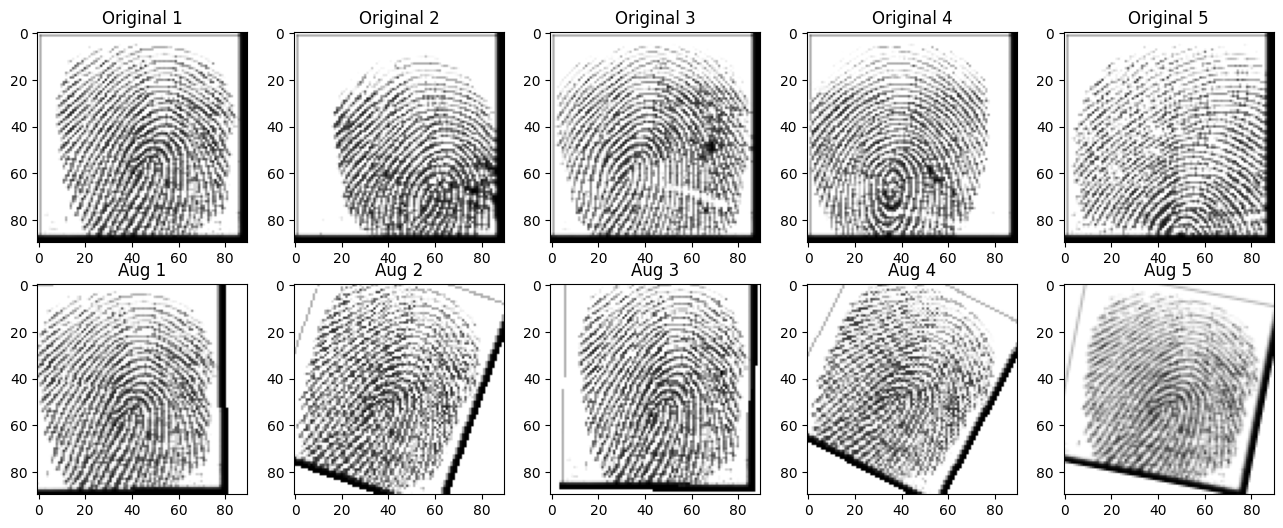

In [31]:
augs = [img_data[0]] * 5

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)
plt.figure(figsize=(16, 6))

# Preview original
for i, img in enumerate(img_data[:5]):
    plt.subplot(2, 5, i+1)
    plt.title(f'Original {i+1}')
    plt.imshow(img.squeeze(), cmap='gray')

# Preview augmentation
for i, aug in enumerate(augs):
    plt.subplot(2, 5, 5 + i+1)
    plt.title(f'Aug {i+1}')
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [32]:
label_real_dict = {}

def get_match_key(y):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    return key

for i, y in enumerate(labels_dict["Real"]):
    key = get_match_key(y)
    label_real_dict[key] = i
print(label_real_dict)

{'100001': 0, '100004': 1, '100002': 2, '100003': 3, '100000': 4, '100011': 5, '100014': 6, '100012': 7, '100013': 8, '100010': 9, '101001': 10, '101004': 11, '101002': 12, '101003': 13, '101000': 14, '101011': 15, '101014': 16, '101012': 17, '101013': 18, '101010': 19, '102001': 20, '102004': 21, '102002': 22, '102003': 23, '102000': 24, '102011': 25, '102014': 26, '102012': 27, '102013': 28, '102010': 29, '103101': 30, '103104': 31, '103102': 32, '103103': 33, '103100': 34, '103111': 35, '103114': 36, '103112': 37, '103113': 38, '103110': 39, '104001': 40, '104004': 41, '104002': 42, '104003': 43, '104000': 44, '104011': 45, '104014': 46, '104012': 47, '104013': 48, '104010': 49, '105001': 50, '105004': 51, '105002': 52, '105003': 53, '105000': 54, '105011': 55, '105014': 56, '105012': 57, '105013': 58, '105010': 59, '106001': 60, '106004': 61, '106002': 62, '106003': 63, '106000': 64, '106011': 65, '106014': 66, '106012': 67, '106013': 68, '106010': 69, '107001': 70, '107004': 71, '

# Create DataGenerator

In [33]:
train_gen = DataGenerator(img_train, label_train, imgs_dict["Real"], label_real_dict, shuffle=True)
val_gen = DataGenerator(img_val, label_val, imgs_dict["Real"], label_real_dict, shuffle=False)

# Create Model

In [34]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

# model
model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 22, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 22, 22, 32)           0         ['model[0][0]',      

# Train

In [38]:
history = model.fit(train_gen, epochs=16, validation_data=val_gen)

1554/1554 [==============================] - 88s 56ms/step - loss: 0.2185 - acc: 0.9109 - val_loss: 0.0871 - val_acc: 0.9816


# Save model

In [63]:
FILE_PATH = resolve(os.path.join(PROJECT_DIR, 'result/finalized_model.pkl'))

joblib.dump(model, FILE_PATH)
loaded_model = joblib.load(FILE_PATH)
print(f"Model saved to {FILE_PATH}")

Model saved to D:\workspace\python\fingerprint-recognition\result\finalized_model.pkl


# Evaluation

1/1 [==============================] - 0s 16ms/step
0.99 2


C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_23844\3952923024.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(round(float(pred_rx), 2), 2)
C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_23844\3952923024.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Input {get_match_key(ry)}: {round(float(pred_rx), 2)}')
C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_23844\3952923024.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title

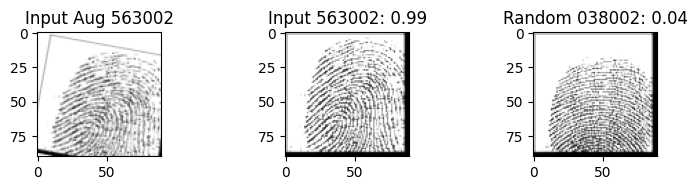

In [68]:
# new user fingerprint input
random_idx = random.randint(0, len(img_val))

random_img = img_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = imgs_dict["Real"][label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = labels_dict["Real"][label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = imgs_dict["Real"][unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = labels_dict["Real"][unmatch_idx]

pred_ux = model.predict([random_img, ux])
print(round(float(pred_rx), 2), 2)

plt.figure(figsize=(8, 4))
plt.subplots_adjust(wspace=1)
plt.subplot(1, 3, 1)
plt.title(f"Input Aug {get_match_key(ry)}")
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title(f'Input {get_match_key(ry)}: {round(float(pred_rx), 2)}')
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title(f"Random {get_match_key(uy)}: {round(float(pred_ux), 2)}")
plt.imshow(ux.squeeze(), cmap='gray')

# Predict

1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 19ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 20ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 19ms/step
0.0
1/1 [==============================] - 0s 19ms/step
0.0
1/1 [==============================] - 0s 19ms/step
0.0
1/1 [==============================] - 0s 20ms/step
0.0
1/1 [==============================] - 0s 16ms/step
0.0
1/1 [==============================] - 0s 18ms/step
0.02
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 16ms/step
0.0
1/1 [==============================] - 0s 19ms/step
0.75
1/1 [==============================] - 0s 17ms/step
0.0
1/1 [==============================] - 0s 18ms

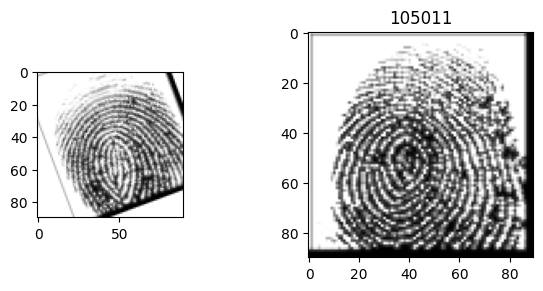

In [62]:
# import the Gabor function from gen_dataset_enhanced.py
from gen_dataset_enhanced import Gabor

img = cv2.imread(os.path.join(PROJECT_DIR, './dataset-raw/Real/1__M_Left_index_finger.BMP'), cv2.IMREAD_GRAYSCALE)
img = Gabor(img)    

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze(), cmap='gray')
count = 0

# Tìm kiếm kết quả phù hợp trong các ảnh đã đăng kí trước
for i in range(1000):
    tmp_img = imgs_dict["Real"][i].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    tmp_label = get_match_key(labels_dict["Real"][i])
    pred = model.predict([img, tmp_img])
    score = round(np.max(pred), 2)
    print(score)
    
    if (score >= 0.9):
        count += 1
        plt.subplot(1, 2,2)
        plt.title(tmp_label)
        plt.imshow(imgs_dict["Real"][i].squeeze(), cmap='gray')
        break